In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models

# from adv_img_generator import generate_adversarial_images, generate_untargeted_adversarial_images_multiple_models
# Apply pca with svm + plotting

2025-06-11 23:59:17.752610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749679157.777507  150878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749679157.784943  150878 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 23:59:17.808891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def build_lenet5(input_shape=(32, 32, 1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(6, kernel_size=5, activation='tanh', input_shape=input_shape, padding='same'),
        layers.AveragePooling2D(pool_size=2),

        layers.Conv2D(16, kernel_size=5, activation='tanh'),
        layers.AveragePooling2D(pool_size=2),

        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [3]:
def lenet5_preprocess(image):
    # Ensure 3D: (28, 28, 1)
    image = tf.expand_dims(image, -1)
    image = tf.image.resize(image, (32, 32))  # Resize to expected size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

In [4]:
# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Pad images from 28x28 → 32x32 (LeNet expects 32x32)
# x_train = tf.pad(x_train[..., tf.newaxis], [[0,0],[2,2],[2,2],[0,0]], "CONSTANT")
# x_test  = tf.pad(x_test[..., tf.newaxis],  [[0,0],[2,2],[2,2],[0,0]], "CONSTANT")

# Normalize
# x_train = tf.cast(x_train, tf.float32) / 255.0
# x_test  = tf.cast(x_test, tf.float32) / 255.0
x_train = lenet5_preprocess(x_train)
x_test = lenet5_preprocess(x_test)

# Build and compile
lenet5 = build_lenet5()
lenet5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
lenet5.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate
loss, acc = lenet5.evaluate(x_test, y_test)
print(f"LeNet Test Accuracy: {acc:.4f}")


2025-06-11 23:59:25.310777: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5


/home/paul/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8655 - loss: 0.4783 - val_accuracy: 0.9685 - val_loss: 0.1036
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9664 - loss: 0.1120 - val_accuracy: 0.9790 - val_loss: 0.0797
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9789 - loss: 0.0705 - val_accuracy: 0.9800 - val_loss: 0.0671
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9818 - val_loss: 0.0591
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9880 - loss: 0.0377 - val_accuracy: 0.9782 - val_loss: 0.0756
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0606
LeNet Test Accuracy: 0.9824


In [5]:
def preprocess(image, preprocess_input, size=(224,224)):
  image = tf.cast(image, tf.float32)
  image = tf.expand_dims(image, axis=-1)
  image = tf.image.grayscale_to_rgb(image)
  image = tf.image.resize(image, size)
  image = preprocess_input(image)
  image = image[None, ...]
  return image

def save_image(tensor, target_folder, filename):

    # Remove batch dimension if present
    if len(tensor.shape) == 4:
        tensor = tensor[0]

    # Encode as JPEG
    encoded = tf.io.encode_jpeg(tensor)

    # Ensure the directory exists
    os.makedirs(target_folder, exist_ok=True)

    # Save to file
    path = os.path.join(target_folder, filename)
    tf.io.write_file(path, encoded)
    # print(f"Image saved to: {path}")


def load_and_preprocess_image(path):
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3)
    return tf.cast(img, tf.float32)

def tensor_range(tensor):
  print(f"Min: {tf.reduce_min(tensor)}, Max: {tf.reduce_max(tensor)}")

In [6]:
def create_adversarial_pattern(input_image, input_label, loss_object, model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def deprocess_resnet(image):
    if len(image.shape) == 4:
        image = image[0]
    
    image = image[..., ::-1]  # BGR → RGB
    image = image + [103.939, 116.779, 123.68]  # Unsubtract means
    image = tf.clip_by_value(image, 0.0, 255.0)
    return image / 255.0  # normalize for display


def generate_untargeted_adversarial_images_multiple_models(img_tensors, target_folder, label, eps, models):

    i, mx = 0, len(img_tensors)
    label = tf.one_hot(label, 10)
    label = tf.reshape(label, (1, 10))
    adversarial_tensors = []

    for img_tensor in img_tensors:
        # print(img_tensor.shape)
        for j, m in enumerate(models.keys()):
            model = models[m][0]
            preprocessor = models[m][1]
            
            image_pr = lenet5_preprocess(img_tensor)
            # plt.imshow(image_pr)
            # plt.title(f"After preprocessing: {image_pr.shape}")
            # plt.show()
            image_pr = tf.expand_dims(image_pr, 0)  # shape: (1, 32, 32, 1)
            # preds = lenet5.predict(image_pr)
            # labels = tf.argmax(preds, axis=1).numpy()
            # print("Predicted labels:", labels[:1])

            loss_object = tf.keras.losses.CategoricalCrossentropy()
            pertubation = create_adversarial_pattern(image_pr, label, loss_object, model)
            # plt.imshow(pertubation[0])
            # plt.title(f"Perturbation with {m}")
            # plt.show()

            if m == "VGG16" or m == "ResNet50":
                adv = image_pr + 100 * eps * pertubation
                adv = tf.clip_by_value(adv, -128, 128)
                final = (deprocess_resnet(adv) - 0.5) * 2

                # tensor_range(depr)
                # plt.imshow(depr)
                # plt.show()
            elif m == "MobileNetV2" or m == "MobileNetV3Small" or m == "InceptionV3":
                adv = image_pr + eps * pertubation
                final = tf.clip_by_value(adv, -1, 1)
            elif m == "MobileNetV3" or m == "MobileNetV3Small":
                adv = image_pr + 255 * eps * pertubation
                final = tf.clip_by_value(adv, 0, 255)
            elif m == "LeNet5":
                # tensor_range(image_pr)
                adv = image_pr + eps * pertubation
                # tensor_range(adv)
                final = tf.clip_by_value(adv, 0.0, 1.0)

            # Convert from [-1, 1] to [0, 255]
            #tensor = (final + 1.0) / 2.0
            #tensor = tf.clip_by_value(tensor, 0.0, 1.0)
            #tensor = tf.image.convert_image_dtype(tensor, dtype=tf.uint8)
            img = tf.squeeze(final)

            # Save
            # file_path = os.path.join(target_folder, f"adv_{i}.png")
            # tf.keras.utils.save_img(file_path, tensor, scale=True)

            if len(final.shape) == 4:
                final = final[0]
            adversarial_tensors.append(final)
            # plt.imshow(img)
            # plt.title(f"After perturbation with model {m} with shape {final.shape}")
            # plt.show()

            img_tensor = final
        # save_image(tensor, target_folder, i)
        # adversarial_tensors.append(tensor)
        # _, cl, conf = get_imagenet_label(all_models["MobileNetV2"][0].predict(preprocess(tensor, all_models["MobileNetV2"][1])))
        # print(f"Classified as {cl} with {conf}% confidence.")

        i += 1
        
    return adversarial_tensors

In [75]:
label_attacked = 7
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test_adv = x_test[y_test == label_attacked]
#print(x_test_seven[0])
x_test_adv.shape


(1028, 28, 28)

In [76]:
# full_path = "./banana_images/data/train/banana/"
target_path = "./adversarial_images/mnist/"
mnist_tensors = x_test_adv[:1000]

model = {"LeNet5": (lenet5, lenet5_preprocess)}
eps = 0.5
label = tf.Variable(label_attacked)


advs = generate_untargeted_adversarial_images_multiple_models(mnist_tensors, target_path, label, eps, model)

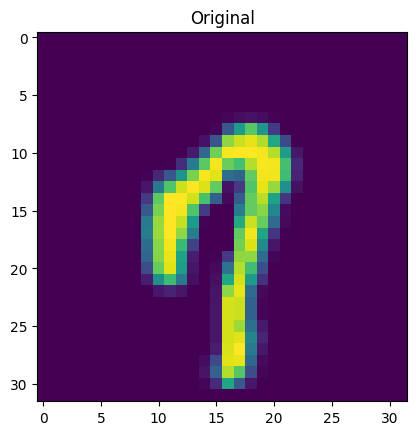

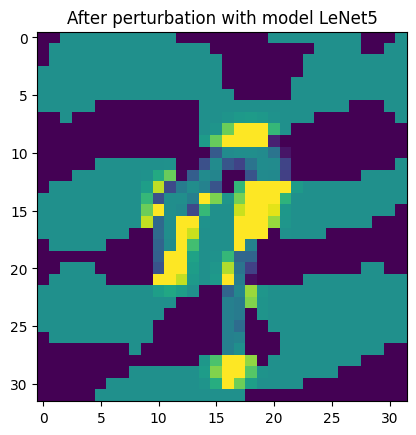

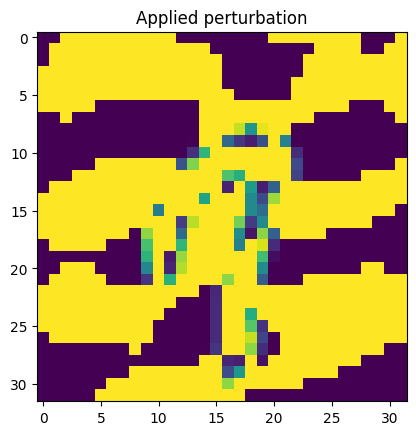

In [77]:
idx = np.random.randint(0, len(advs) - 1)

og = lenet5_preprocess(x_test_adv[idx])
plt.imshow(og)
plt.title(f"Original")
plt.show()

# mod = np.array(tf.image.resize(advs[0], (28, 28))).squeeze()
mod = advs[idx]
plt.imshow(mod)
plt.title(f"After perturbation with model LeNet5")
plt.show()

diff = mod - og
plt.imshow(abs(diff))
plt.title("Applied perturbation")
plt.show()

In [78]:
# Evaluate
x_adv = tf.convert_to_tensor(advs)
print(x_adv.shape)
tensor_range(x_adv)
preds = lenet5.predict(x_adv)
labels = tf.argmax(preds, axis=1).numpy()
# print("Predicted labels:", labels)

total = len(labels)
rate = len(labels[labels == label_attacked])

print(f"Evasion rate: {((total - rate) / total) * 100: .2f}")

(1000, 32, 32, 1)
Min: 0.0, Max: 1.0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evasion rate:  100.00


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_flat = x_train.reshape(-1, 28*28).astype("float32")
x_test_flat = x_test.reshape(-1, 28*28).astype("float32")

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)
# x_train_scaled = lenet5_preprocess(x_train)
# x_test_scaled = lenet5_preprocess(x_test)

subset = 8000
clf = svm.SVC(kernel='rbf', C=5, gamma='scale')  # You can try 'linear' too
clf.fit(x_train_scaled[:subset], y_train[:subset])

y_pred = clf.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

Test accuracy: 0.96


In [55]:
subset = 4000
x_train_resized = tf.image.resize(x_train[..., None], (32, 32)).numpy()
x_train_flat = x_train_resized.reshape((len(x_train), -1))
x_test_resized = tf.image.resize(x_test[..., None], (32, 32)).numpy()
x_test_flat = x_test_resized.reshape((len(x_test), -1))

scaler_32 = MinMaxScaler()
x_train_scaled = scaler_32.fit_transform(x_train_flat)
x_test_scaled = scaler_32.transform(x_test_flat)

svm_model_32 = svm.SVC()
svm_model_32.fit(x_train_scaled[:subset], y_train[:subset])

y_pred = svm_model_32.predict(x_test_scaled)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.2f}")

Min: 0.0, Max: 1.0
[7 2 1 ... 4 5 6]
Test accuracy: 0.95


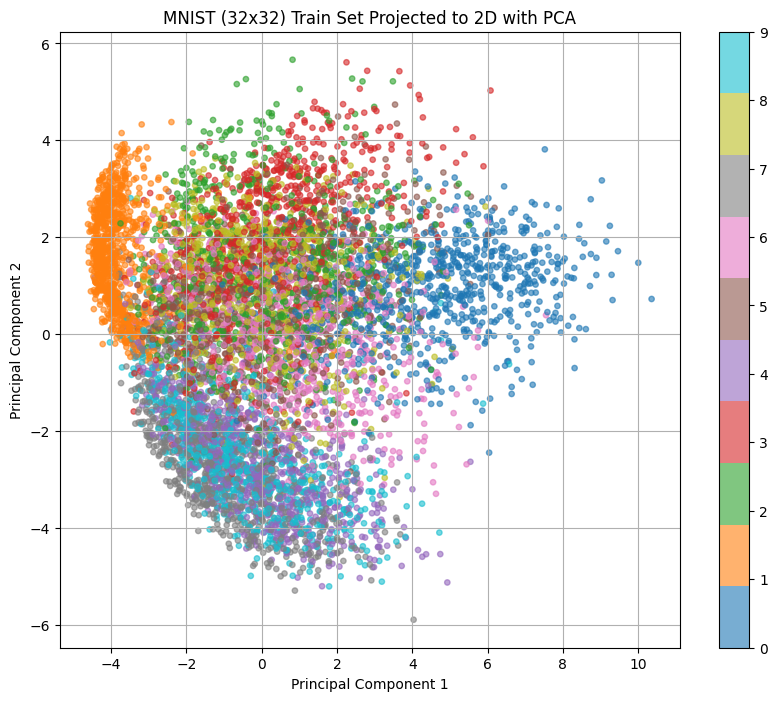

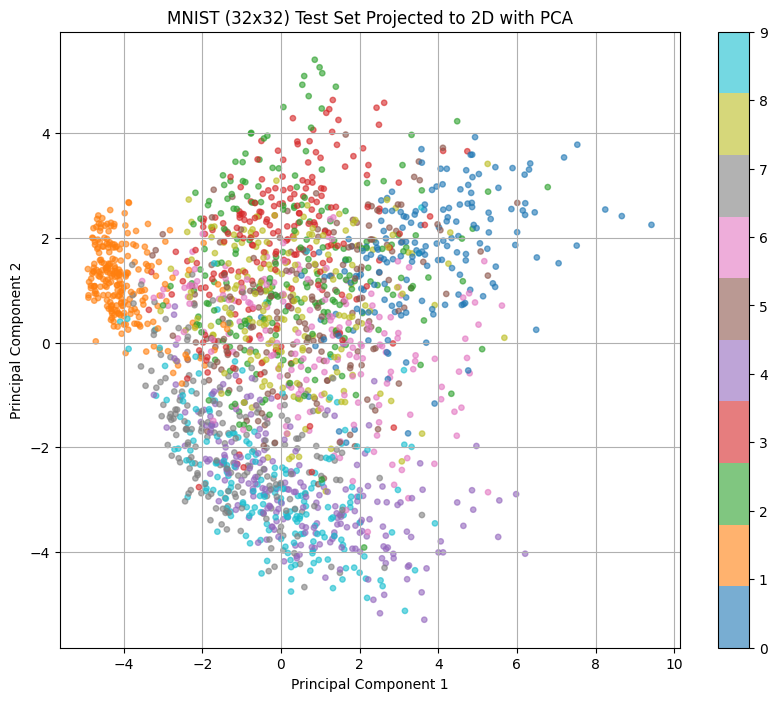

In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

limit = 8000
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled[:limit])

# Plot the 2D PCA representation, colored by true label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train[:limit], cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, ticks=range(10))
plt.title("MNIST (32x32) Train Set Projected to 2D with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Apply PCA to reduce to 2D
limit = 2000
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test_scaled[:limit])

# Plot the 2D PCA representation, colored by true label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test[:limit], cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, ticks=range(10))
plt.title("MNIST (32x32) Test Set Projected to 2D with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [79]:
# x_adv_resized = tf.image.resize(x_adv, (28, 28)).numpy().squeeze()
# print(x_adv_resized.shape)
x_adv_scaled = np.array(x_adv).reshape(len(x_adv), -1) # scaler_32.transform(np.array(x_adv).reshape(len(x_adv), -1))

preds = svm_model_32.predict(x_adv_scaled)
# labels = np.argmax(preds, axis=1).numpy()
print("Predicted labels:", preds)

total = len(preds)
rate = len(preds[preds == label_attacked])

print(f"Evasion rate: {((total - rate) / total) * 100: .2f}")

Predicted labels: [3 3 3 2 2 3 3 2 3 3 7 9 3 3 2 8 2 3 3 2 3 8 2 3 9 3 3 3 2 3 2 3 3 2 2 8 8
 3 5 3 3 3 3 3 3 3 2 2 3 8 8 8 8 3 3 3 3 5 2 3 3 2 3 4 3 3 2 2 2 3 2 2 3 5
 0 8 2 3 2 3 3 2 2 3 9 3 2 3 2 8 2 3 3 8 5 3 2 5 5 5 5 2 2 3 3 8 9 3 3 5 3
 2 3 2 3 3 8 3 5 3 8 3 3 9 2 5 2 2 3 5 2 2 3 2 5 3 9 3 3 3 2 3 3 2 5 2 5 3
 2 5 5 3 3 0 5 3 5 2 3 3 5 3 9 2 3 8 5 2 5 2 3 3 3 5 2 3 0 3 2 2 3 2 2 9 3
 2 3 2 3 3 2 3 2 9 5 2 3 3 8 3 2 5 3 3 3 2 9 5 3 3 3 5 2 5 2 3 0 9 3 3 2 9
 3 2 2 3 2 3 2 3 3 3 0 3 3 2 5 3 3 2 2 2 5 9 3 8 3 3 3 3 2 3 3 9 3 5 3 5 8
 8 0 5 8 2 2 3 3 3 3 2 2 3 3 3 6 5 2 9 3 2 2 2 5 3 3 2 2 5 3 2 2 3 3 2 2 3
 3 2 3 2 2 3 2 3 5 2 3 5 5 5 2 8 5 2 3 3 3 5 3 3 3 2 2 3 5 9 2 2 2 2 2 5 5
 3 5 3 5 8 2 2 2 9 2 3 9 2 2 9 2 3 3 3 0 2 3 3 0 3 3 3 2 2 5 2 2 2 2 2 2 5
 3 2 2 2 3 3 3 2 3 2 3 8 3 3 5 3 0 2 3 3 3 9 5 3 6 3 2 2 5 5 2 2 2 3 2 2 3
 3 3 3 5 5 3 3 3 5 3 3 3 3 8 2 2 2 3 8 2 2 2 3 5 2 5 5 2 2 3 3 5 5 2 2 3 5
 2 3 3 3 3 2 2 2 8 3 2 3 5 8 2 5 3 2 2 5 2 3 3 5 2 2 8 8 3 3 2 5 5 3 3 2 2
 5 2 3 

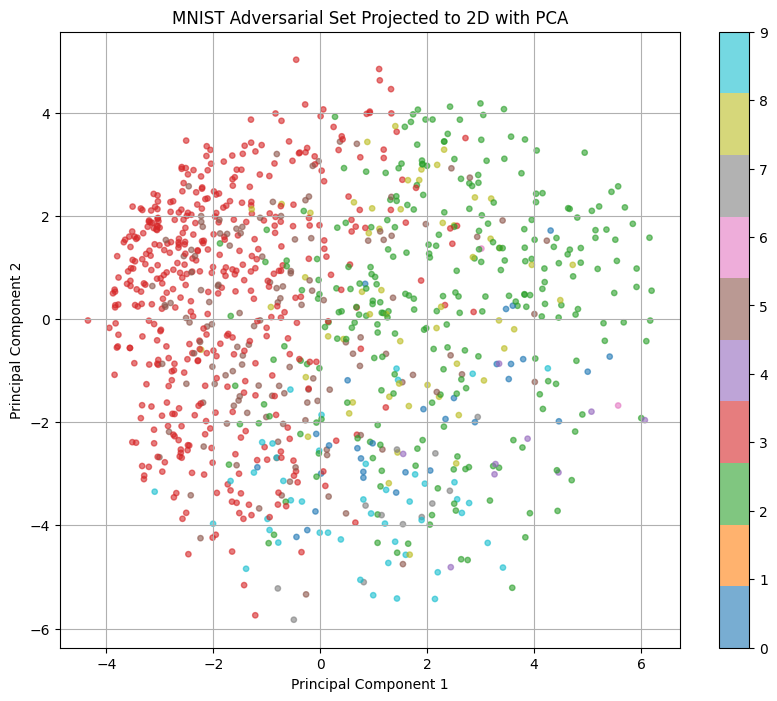

In [80]:
pca = PCA(n_components=2)
x_adv_pca = pca.fit_transform(x_adv_scaled)

# Plot the 2D PCA representation, colored by true label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_adv_pca[:, 0], x_adv_pca[:, 1], c=preds, cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, ticks=range(10))
plt.title("MNIST Adversarial Set Projected to 2D with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [ ]:
epsilons = [0, 0.005, 0.01, 0.05, 0.1]
(x_train, y_train), (x_test, y_test) = mnist.load_data()
evasion_rates_combined = {}

for eps in epsilons:
    for l in range(10):
        # evasion_rates = {}
        x_train_adv = x_train[y_train == l][:100]

        model = {"LeNet5": (lenet5, lenet5_preprocess)}
        label = tf.Variable(l)

        advs = generate_untargeted_adversarial_images_multiple_models(x_train_adv, target_path, label, eps, model)

        # Evaluate
        x_adv = tf.convert_to_tensor(advs)
        preds = lenet5.predict(x_adv)
        labels = tf.argmax(preds, axis=1).numpy()
        print("Predicted labels:", labels)

        total = len(labels)
        rate = len(labels[labels != l])
        print("Num fooled:", rate)
        rate = (rate / total) * 100
        
        print(f"Attacked label: {l}, Epsilon: {eps}")
        print(f"Evasion rate: {rate: .2f}")

        if l not in evasion_rates_combined.keys():
            evasion_rates_combined[l] = [rate]
        else:
            evasion_rates_combined[l].append(rate)
print(evasion_rates_combined)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Num fooled: 0
Attacked label: 0, Epsilon: 0
Evasion rate:  0.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Num fooled: 0
Attacked label: 1, Epsilon: 0
Evasion rate:  0.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Predicted labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Num fooled: 0
Attacked label: 2, Epsilon: 0
Evasion rate:  0.00
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

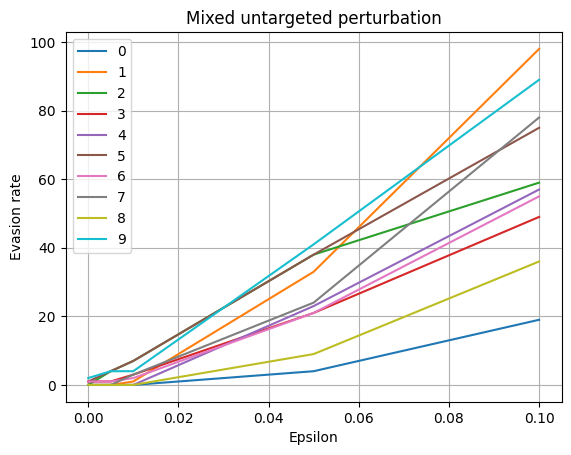

In [ ]:
for label, values in evasion_rates_combined.items():
    plt.plot(epsilons, values, label=label)

plt.xlabel("Epsilon")
plt.ylabel("Evasion rate")
plt.title("Mixed untargeted perturbation")
plt.legend()
plt.grid(True)
plt.show()

### From SVM to LeNet5